# Results evaluator
This notebook uses the images folders generated using [PIPELINE 1], the image metrics generated using [PIPELINE 2], the model error and confidence from [KITTI ADS] or [DONKEY ADS], and the attention mask error calculated using [PIPELINE 3] to evaluate results.

## Usage:
Run all cells

## Requirements:
"./[type]/content/output_plots/[source]/[source]"
"./[type]/content/output_plots/[source]/[source]_mask"
"./[type]/content/output_plots/[source]/[source]_mask_error"
"./[type]/content/output_plots/[source]/[source]_additional_mask"
"./[type]/content/output_plots/[source]/[source]_metrics_results"
"./[type]/content/output_plots/[source]/[source]_pred"
"./[type]/content/output_plots/[source]/[source]_[ADS]_conf"
"./[type]/content/output_plots/[source]/[source]_[ADS]_loss"
"./[type]/content/output_plots/[source]/[source]_att_loss" 

In [1]:
from scipy.stats import pearsonr
import cv2, os, glob, re, json
import numpy as np
import tensorflow as tf
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import sqrt

import numpy as np
from numpy import mean
from numpy import var
from scipy.stats import wilcoxon
from statsmodels.stats.power import FTestAnovaPower
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import statistics

In [3]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

In [23]:
type="donkey"
data_directory="./"+type+"/content/output_plots/"
sources={}

sources['sim']=['sim']
sources['real']=['real']
# sources['cyclegan']=["cyclegan_1","cyclegan_2","cyclegan_3"]
# sources['pix2pix_mask_manual']=["pix2pix_mask_1_sim","pix2pix_mask_2_sim","pix2pix_mask_3_sim"]

if type=="kitti":
    sources['cyclegan']=["cyclegan_1","cyclegan_8","cyclegan_28"]
    sources['pix2pix_mask_manual']=["pix2pix_mask_39_sim","pix2pix_mask_57_sim","pix2pix_mask_290_sim"]
elif type=="donkey":
    sources['cyclegan']=['cyclegan_2','cyclegan_4','cyclegan_5']
    sources['pix2pix_mask_manual']=['pix2pix_mask_20_sim','pix2pix_mask_70_sim','pix2pix_mask_120_sim']

plot=True
if type=="kitti":
    height,width=374,1238
    road=0
    additional_id=3
    additional_id_init=13
    dataset_ids=["*"]
elif type=="donkey":
    height,width=140,320
    road=1
    additional_id=1
    additional_id_init=2
    dataset_ids=["0001"]

image_path_dict={}
mask_path_dict={}
mask_additional_path_dict={}
mask_error_path_dict={}
image_metrics_path_dict={}
model_path_dict={}
model_loss_path_dict={}
model_conf_path_dict={}
model_att_path_dict={}

In [24]:
for model_type, models in sources.items():
    for source_name in models:
        image_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"/"
        mask_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_mask/"
        mask_error_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_mask_error/"
        mask_additional_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_additional_mask/"
        image_metrics_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_metrics_results/"
        if type=="kitti":
            model_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_pred/"
            model_loss_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_yolo_loss/"
            model_conf_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_yolo_conf/"
            model_att_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_att_loss/"
        elif type=="donkey":
            model_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_pred/"
            model_loss_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_driver_loss/"
            model_conf_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_driver_conf/"
            model_att_path_dict[model_type+"__"+source_name]=data_directory+model_type+"/"+source_name+"_att_loss/"

In [25]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def cast_to_int32(image):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.cast(image * 255, tf.int32)
    return image

In [26]:
for dataset_id in dataset_ids:
    data_list=sorted(glob.glob(data_directory+'cyclegan/'+sources['cyclegan'][0]+'/'+dataset_id+'_*.png'),key=natural_sort_key)
    filenames=[]
    for path in data_list:
        filenames.append(path.split("/")[-1].split(".")[0])
    
    image_metrics=[]
    with open(image_metrics_path_dict['sim__'+sources['sim'][0]]+filenames[0]+".json", "r") as json_file:
                    error_data = json.load(json_file)
                    for key, value in error_data.items():
                        image_metrics.append(key)
    mask_errors=[]
    with open(mask_error_path_dict['cyclegan__'+sources['cyclegan'][0]]+filenames[0]+".json", "r") as json_file:
                    error_data = json.load(json_file)
                    for key, value in error_data.items():
                        mask_errors.append(key)
                        
    model_loss_dict={}
    model_conf_dict={}
    image_metrics_dict={}
    mask_error_dict={}
    model_att_dict={}
    for model_type, models in sources.items():
        for source_name in models:
            model_loss_dict[model_type+"__"+source_name]=[]
            model_conf_dict[model_type+"__"+source_name]=[]
            model_att_dict[model_type+"__"+source_name]=[]
            image_metrics_dict[model_type+"__"+source_name]={}
            mask_error_dict[model_type+"__"+source_name]={}
            for image_metric in image_metrics:
                image_metrics_dict[model_type+"__"+source_name][image_metric]=[]
            if(source_name!='real'):
                for mask_error in mask_errors:
                    mask_error_dict[model_type+"__"+source_name][mask_error]=[]
    
    for file in filenames:
        for model_type, models in sources.items():
            for source_name in models:
                    if(source_name!='real'):
                        with open(mask_error_path_dict[model_type+"__"+source_name]+file+".json", "r") as json_file:
                            error_data = json.load(json_file)
                            for key, value in error_data.items():
                                        if source_name=='sim' and key=='sim_real':
                                            mask_error_dict[model_type+"__"+source_name][key].append(float(value))
                                            mask_error_dict[model_type+"__"+source_name]['real'].append(float(value))
                                        else:
                                            mask_error_dict[model_type+"__"+source_name][key].append(float(value))
                    
                
                        with open(image_metrics_path_dict[model_type+"__"+source_name]+file+".json", "r") as json_file:
                            error_data = json.load(json_file)
                            
                            for metric_name, value in error_data.items():
                                        if (metric_name == 'kde_probs' or metric_name == 'inception_score' or metric_name == 'inception_std_score' or metric_name=="kid_score" or metric_name=="fid_score"):
                                            image_metrics_dict[model_type+"__"+source_name][metric_name].append(float(value))
                                        elif metric_name!='perceptual_distances':
                                            
                                            image_metrics_dict[model_type+"__"+source_name][metric_name].append(float(value))
                    
                    f = open(model_loss_path_dict[model_type+"__"+source_name]+file+".txt", "r")
                    model_loss=float(f.read())
                    model_loss_dict[model_type+"__"+source_name].append(model_loss)

                    f = open(model_conf_path_dict[model_type+"__"+source_name]+file+".txt", "r")
                    model_conf=float(f.read())
                    model_conf_dict[model_type+"__"+source_name].append(model_conf)

                    f = open(model_att_path_dict[model_type+"__"+source_name]+file+".txt", "r")
                    model_att=float(f.read())
                    model_att_dict[model_type+"__"+source_name].append(model_att)

    
    correlation_dict={}
    relative_correlation_dict={}

    y_min_model = min(np.min(model_loss_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    y_max_model = max(np.max(model_loss_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
    y_max_mask=0
    for model_type, models in sources.items():
            for source_name in models:
                if(source_name!='real'):
                            
                            mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                            new_list = set(mask_error)
                            new_list.remove(max(new_list))
                            # print("new:",max(new_list),"todo:",max(mask_error))
                            mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                            y_max_mask=max(max(mask_error),y_max_mask)
    
    
    y_min_mask = min(np.min(mask_error_dict[model_type + "__" + source_name]["additional"]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
    for model_type, models in sources.items():
            for source_name in models:
                correlation_dict[model_type+"__"+source_name]={}
                relative_correlation_dict[model_type+"__"+source_name]={}
                if(source_name!='real' and source_name!='real'):
                            relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_loss_dict["real__real"], model_loss_dict[model_type+"__"+source_name])]
                            relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
                            mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                            new_list = set(mask_error)
                            new_list.remove(max(new_list))
                            mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                            pears=pearsonr(model_loss_dict[model_type+"__"+source_name], mask_error)
                            pears_rel=pearsonr(relative_loss, mask_error)
                            correlation_dict[model_type+"__"+source_name]["mask_error"]=pears
                            relative_correlation_dict[model_type+"__"+source_name]["mask_error"]=pears_rel
                            for image_metric in image_metrics:
                                if(metric_name == 'kde_probs' or image_metric!="inception_score" and image_metric!="fid_score" and image_metric!="kid_score"):# fig, ax1 = plt.subplots(figsize=(40, 8))
                                    metric_vals=image_metrics_dict[model_type+"__"+source_name][image_metric]
                                    metric_vals = np.where(np.isinf(metric_vals), 999, metric_vals)
                                    metric_vals = np.where(np.isnan(metric_vals), -999, metric_vals)
                                    pears=pearsonr(model_loss_dict[model_type+"__"+source_name], metric_vals)
                                    correlation_dict[model_type+"__"+source_name][image_metric]=pears
                                    pears_rel=pearsonr(relative_loss, metric_vals)
                                    relative_correlation_dict[model_type+"__"+source_name][image_metric]=pears_rel

/Users/lambertenghi/miniconda3/envs/tfEnv4/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4847: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


In [28]:
correlation_dict = {}

for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            correlations = relative_correlation_dict.get(model_type + "__" + source_name, {})
            for metric, correlation in correlations.items():
                if metric not in correlation_dict:
                    correlation_dict[metric] = {}
                correlation_dict[metric][source_name] = {"Correlation": correlation[0], "p-value": correlation[1]}

all_source_names = sources['cyclegan'] + sources['pix2pix_mask_manual']
table_headers = ["Metric"] + [f"{source_name}" for source_name in all_source_names]

table_headers.insert(1, "Value")

table_data = []
for metric, source_correlations in correlation_dict.items():
    metric_row = [metric]
    for source_name in all_source_names:
        if source_name in source_correlations:
            correlation_data = source_correlations[source_name]
            correlation_value = f"{correlation_data['Correlation']:.2f}"
            p_value = correlation_data['p-value']
            if p_value <= 0.05:
                correlation_value = r"\textbf{" + correlation_value + "}"
            metric_row.append(correlation_value)
        else:
            metric_row.append("(N/A)")
    table_data.append(metric_row)

latex_table = tabulate(table_data, headers=table_headers, tablefmt="latex_raw")

latex_table_with_subcolumns = r"\begin{tabular}{|c|" + "c|" * len(all_source_names) + r"} \hline" + "\n"
header_row = table_headers[0]
for source_name in all_source_names:
    header_row += r" & " + source_name
header_row += r" \\ \hline"
latex_table_with_subcolumns += header_row + "\n"
for row in table_data:
    latex_table_with_subcolumns += " & ".join(row) + r" \\ \hline" + "\n"
latex_table_with_subcolumns += r"\end{tabular}"

print("Model error correlation table")
print(latex_table_with_subcolumns)

Model error correlation table
\begin{tabular}{|c|c|c|c|c|c|c|} \hline
Metric & cyclegan_2 & cyclegan_4 & cyclegan_5 & pix2pix_mask_20_sim & pix2pix_mask_70_sim & pix2pix_mask_120_sim \\ \hline
mask_error & \textbf{0.39} & \textbf{0.35} & \textbf{0.44} & \textbf{0.42} & \textbf{0.31} & \textbf{0.38} \\ \hline
ssim_scores & \textbf{-0.31} & \textbf{-0.28} & \textbf{-0.39} & -0.09 & -0.03 & \textbf{-0.15} \\ \hline
psnr_scores & \textbf{-0.33} & \textbf{-0.34} & \textbf{-0.45} & -0.12 & -0.08 & -0.12 \\ \hline
mse_scores & \textbf{0.34} & \textbf{0.34} & \textbf{0.45} & 0.12 & 0.07 & 0.12 \\ \hline
cosine_similarities & 0.03 & 0.00 & -0.07 & -0.06 & \textbf{-0.14} & 0.02 \\ \hline
corr_coeffs & \textbf{-0.33} & \textbf{-0.29} & \textbf{-0.35} & \textbf{-0.25} & \textbf{-0.21} & \textbf{-0.27} \\ \hline
text_sim & \textbf{-0.15} & -0.12 & -0.06 & \textbf{-0.26} & \textbf{-0.18} & -0.00 \\ \hline
wd_score & 0.07 & 0.02 & \textbf{-0.15} & -0.07 & -0.07 & \textbf{-0.16} \\ \hline
kl_div & \te

In [30]:
    correlation_dict={}
    relative_correlation_dict={}

    y_min_model = min(np.min(model_att_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    y_max_model = max(np.max(model_att_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
    y_max_mask=0
    for model_type, models in sources.items():
            for source_name in models:
                if(source_name!='real'):
                            
                            mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                            new_list = set(mask_error)
                            new_list.remove(max(new_list))
                            mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                            y_max_mask=max(max(mask_error),y_max_mask)
    
    
    y_min_mask = min(np.min(mask_error_dict[model_type + "__" + source_name]["additional"]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
    for model_type, models in sources.items():
            for source_name in models:
                correlation_dict[model_type+"__"+source_name]={}
                relative_correlation_dict[model_type+"__"+source_name]={}
                if(source_name!='real' and source_name!='real'):
                            relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_att_dict["real__real"], model_att_dict[model_type+"__"+source_name])]
                            relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
                            mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                            new_list = set(mask_error)
                            new_list.remove(max(new_list))
                            mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                            pears=pearsonr(model_att_dict[model_type+"__"+source_name], mask_error)
                            pears_rel=pearsonr(relative_loss, mask_error)
                            correlation_dict[model_type+"__"+source_name]["mask_error"]=pears
                            relative_correlation_dict[model_type+"__"+source_name]["mask_error"]=pears_rel
                            for image_metric in image_metrics:
                                if(metric_name == 'kde_probs' or image_metric!="inception_score" and image_metric!="fid_score" and image_metric!="kid_score"):# fig, ax1 = plt.subplots(figsize=(40, 8))
                                    metric_vals=image_metrics_dict[model_type+"__"+source_name][image_metric]
                                    metric_vals = np.where(np.isinf(metric_vals), 999, metric_vals)
                                    metric_vals = np.where(np.isnan(metric_vals), -999, metric_vals)
                                    pears=pearsonr(model_att_dict[model_type+"__"+source_name], metric_vals)
                                    correlation_dict[model_type+"__"+source_name][image_metric]=pears
                                    pears_rel=pearsonr(relative_loss, metric_vals)
                                    relative_correlation_dict[model_type+"__"+source_name][image_metric]=pears_rel

In [31]:
correlation_dict = {}

for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            correlations = relative_correlation_dict.get(model_type + "__" + source_name, {})
            for metric, correlation in correlations.items():
                if metric not in correlation_dict:
                    correlation_dict[metric] = {}
                correlation_dict[metric][source_name] = {"Correlation": correlation[0], "p-value": correlation[1]}

all_source_names = sources['cyclegan'] + sources['pix2pix_mask_manual']
table_headers = ["Metric"] + [f"{source_name}" for source_name in all_source_names]

table_headers.insert(1, "Value")

table_data = []
for metric, source_correlations in correlation_dict.items():
    metric_row = [metric]
    for source_name in all_source_names:
        if source_name in source_correlations:
            correlation_data = source_correlations[source_name]
            correlation_value = f"{correlation_data['Correlation']:.2f}"
            p_value = correlation_data['p-value']
            if p_value <= 0.05:
                correlation_value = r"\textbf{" + correlation_value + "}"
            metric_row.append(correlation_value)
        else:
            metric_row.append("(N/A)")
    table_data.append(metric_row)

latex_table = tabulate(table_data, headers=table_headers, tablefmt="latex_raw")

latex_table_with_subcolumns = r"\begin{tabular}{|c|" + "c|" * len(all_source_names) + r"} " + "\n"
header_row = table_headers[0]
for source_name in all_source_names:
    header_row += r" & " + source_name
header_row += r" \\ "
latex_table_with_subcolumns += header_row + "\n"
for row in table_data:
    latex_table_with_subcolumns += " & ".join(row) + r" \\ " + "\n"
latex_table_with_subcolumns += r"\end{tabular}"

print("Attention error correlation table")
print(latex_table_with_subcolumns)

Attention error correlation table
\begin{tabular}{|c|c|c|c|c|c|c|} 
Metric & cyclegan_2 & cyclegan_4 & cyclegan_5 & pix2pix_mask_20_sim & pix2pix_mask_70_sim & pix2pix_mask_120_sim \\ 
mask_error & 0.06 & -0.04 & \textbf{-0.16} & 0.10 & -0.08 & \textbf{-0.45} \\ 
ssim_scores & \textbf{-0.34} & \textbf{-0.37} & \textbf{-0.20} & -0.03 & 0.05 & \textbf{0.35} \\ 
psnr_scores & \textbf{-0.38} & \textbf{-0.36} & \textbf{-0.31} & -0.02 & -0.10 & \textbf{0.18} \\ 
mse_scores & \textbf{0.38} & \textbf{0.36} & \textbf{0.31} & 0.01 & 0.10 & \textbf{-0.17} \\ 
cosine_similarities & -0.14 & -0.01 & -0.06 & -0.11 & 0.14 & -0.00 \\ 
corr_coeffs & -0.05 & 0.09 & \textbf{0.25} & 0.07 & 0.08 & \textbf{0.38} \\ 
text_sim & -0.04 & -0.07 & \textbf{-0.18} & \textbf{-0.18} & \textbf{-0.16} & \textbf{-0.16} \\ 
wd_score & -0.05 & -0.00 & -0.08 & \textbf{-0.19} & 0.03 & \textbf{0.22} \\ 
kl_div & \textbf{0.27} & \textbf{0.29} & \textbf{0.37} & -0.01 & -0.09 & -0.12 \\ 
hist_inter & -0.13 & 0.10 & \textbf{-0.1

In [32]:
correlation_dict={}
relative_correlation_dict={}

y_min_model = min(np.min(model_conf_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
y_max_model = max(np.max(model_conf_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')


y_max_mask=0
for model_type, models in sources.items():
        for source_name in models:
            if(source_name!='real'):
                        
                        mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
                        new_list = set(mask_error)
                        new_list.remove(max(new_list))
                        mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                        y_max_mask=max(max(mask_error),y_max_mask)


y_min_mask = min(np.min(mask_error_dict[model_type + "__" + source_name]["additional"]) for model_type, models in sources.items() for source_name in models if source_name != 'real')


for model_type, models in sources.items():
        for source_name in models:
            correlation_dict[model_type+"__"+source_name]={}
            relative_correlation_dict[model_type+"__"+source_name]={}
            if(source_name!='real' and source_name!='real'):
                        
                    
                        if(type=='kitti'):
                            relative_loss=[-abs(b_i-a_i)  for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
                        else:
                            relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
                            
                        new_list = set(mask_error)
                        new_list.remove(max(new_list))
                        mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
                        pears=pearsonr(model_conf_dict[model_type+"__"+source_name], mask_error)
                        pears_rel=pearsonr(relative_loss, mask_error)
                        correlation_dict[model_type+"__"+source_name]["mask_error"]=pears
                        relative_correlation_dict[model_type+"__"+source_name]["mask_error"]=pears_rel
                        for image_metric in image_metrics:
                            if(metric_name == 'kde_probs' or image_metric!="inception_score" and image_metric!="fid_score" and image_metric!="kid_score"):# fig, ax1 = plt.subplots(figsize=(40, 8))
                                metric_vals=image_metrics_dict[model_type+"__"+source_name][image_metric]
                                metric_vals = np.where(np.isinf(metric_vals), 999, metric_vals)
                                metric_vals = np.where(np.isnan(metric_vals), -999, metric_vals)
                                pears=pearsonr(model_conf_dict[model_type+"__"+source_name], metric_vals)
                                correlation_dict[model_type+"__"+source_name][image_metric]=pears
                                pears_rel=pearsonr(relative_loss, metric_vals)
                                relative_correlation_dict[model_type+"__"+source_name][image_metric]=pears_rel

In [33]:
correlation_dict = {}

for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            correlations = relative_correlation_dict.get(model_type + "__" + source_name, {})
            for metric, correlation in correlations.items():
                if metric not in correlation_dict:
                    correlation_dict[metric] = {}
                correlation_dict[metric][source_name] = {"Correlation": correlation[0], "p-value": correlation[1]}

all_source_names = sources['cyclegan'] + sources['pix2pix_mask_manual']
table_headers = ["Metric"] + [f"{source_name}" for source_name in all_source_names]

table_headers.insert(1, "Value")

table_data = []
for metric, source_correlations in correlation_dict.items():
    metric_row = [metric]
    for source_name in all_source_names:
        if source_name in source_correlations:
            correlation_data = source_correlations[source_name]
            correlation_value = f"{correlation_data['Correlation']:.2f}"
            p_value = correlation_data['p-value']
            if p_value <= 0.05:
                correlation_value = r"\textbf{" + correlation_value + "}"
            metric_row.append(correlation_value)
        else:
            metric_row.append("(N/A)")
    table_data.append(metric_row)

latex_table = tabulate(table_data, headers=table_headers, tablefmt="latex_raw")

latex_table_with_subcolumns = r"\begin{tabular}{|c|" + "c|" * len(all_source_names) + r"} " + "\n"
header_row = table_headers[0]
for source_name in all_source_names:
    header_row += r" & " + source_name
header_row += r" \\ "
latex_table_with_subcolumns += header_row + "\n"
for row in table_data:
    latex_table_with_subcolumns += " & ".join(row) + r" \\ " + "\n"
latex_table_with_subcolumns += r"\end{tabular}"

print("Confidence error correlation table")
print(latex_table_with_subcolumns)

Confidence error correlation table
\begin{tabular}{|c|c|c|c|c|c|c|} 
Metric & cyclegan_2 & cyclegan_4 & cyclegan_5 & pix2pix_mask_20_sim & pix2pix_mask_70_sim & pix2pix_mask_120_sim \\ 
mask_error & \textbf{0.16} & \textbf{0.17} & \textbf{0.16} & \textbf{0.18} & 0.13 & \textbf{0.19} \\ 
ssim_scores & -0.14 & -0.13 & -0.05 & -0.12 & -0.07 & -0.13 \\ 
psnr_scores & -0.11 & -0.02 & -0.08 & -0.13 & -0.01 & -0.11 \\ 
mse_scores & 0.11 & 0.02 & 0.08 & 0.13 & 0.01 & 0.11 \\ 
cosine_similarities & -0.04 & -0.10 & -0.05 & -0.03 & -0.13 & 0.02 \\ 
corr_coeffs & -0.12 & -0.10 & \textbf{-0.17} & -0.07 & -0.10 & \textbf{-0.14} \\ 
text_sim & 0.10 & 0.11 & \textbf{0.20} & -0.10 & -0.14 & -0.07 \\ 
wd_score & 0.10 & 0.07 & 0.07 & 0.13 & 0.10 & 0.07 \\ 
kl_div & \textbf{0.21} & 0.10 & 0.07 & 0.11 & \textbf{0.18} & \textbf{0.19} \\ 
hist_inter & 0.11 & 0.08 & 0.13 & 0.11 & \textbf{0.20} & -0.01 \\ 
perc_dist & \textbf{0.18} & \textbf{0.25} & 0.12 & \textbf{0.15} & \textbf{0.19} & \textbf{0.30} \\ 
kde_

In [34]:
# Initialize dictionaries to store the average values for each metric
average_metrics = {
    'inception_score': {},
    'kid_score': {},
    'fid_score': {},
    'model_error': {},
    'confidence': {},
    'attention': {}
}

# print(model_att_dict["sim__sim"])



# Iterate through image metrics and sources
for image_metric in image_metrics:
    if(image_metric=='inception_score' or image_metric=="kid_score" or image_metric=="fid_score"):
        for model_type, models in sources.items():
            for source_name in models:
                if source_name != 'real':
                    # Get the data for the current source and image metric
                    data = image_metrics_dict[model_type + "__" + source_name][image_metric]
        
                    # Calculate the average value for the current metric
                    average_value = sum(data) / len(data)
        
                    # Store the average value in the corresponding dictionary
                    average_metrics[image_metric][source_name] = average_value

                    data = model_loss_dict[model_type+"__"+source_name]
                    data=[abs(x-y) for x,y in zip(data,model_loss_dict["real__real"])]
                    # Calculate the average value for the current metric
                    average_value = sum(data) / len(data)

                    average_metrics["model_error"][source_name] = average_value

                    data = model_att_dict[model_type+"__"+source_name]
                    data=[abs(x-y) for x,y in zip(data,model_att_dict["real__real"])]
        
                    # Calculate the average value for the current metric
                    average_value = sum(data) / len(data)

                    average_metrics["attention"][source_name] = average_value

                    data = model_conf_dict[model_type+"__"+source_name]
                    # data=[1-abs(x-y) for x,y in zip(data,model_conf_dict["real__real"])]
                    # if(type=='kitti'):
                    data=[1-abs(abs(a_i-b_i)-a_i) if b_i>0.5 else  1-abs(abs(a_i-0.5)-a_i) for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
                    # else:
                    #     data=[abs(a_i-b_i)  for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
            
                    # Calculate the average value for the current metric
                    average_value = sum(data) / len(data)

                    average_metrics["confidence"][source_name] = average_value

In [35]:
source_names = list(average_metrics['inception_score'].keys())
x = np.arange(len(source_names))


for correlation_metric in ['inception_score','kid_score','fid_score']:
    model_errors = [average_metrics['model_error'][source_name] for source_name in source_names]
    metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]
    
    correlation, sign = pearsonr(model_errors, metric_values)
    
    print(f"Correlation between Model Error and {correlation_metric}: {correlation:.2f} significance {sign}")

for correlation_metric in ['inception_score','kid_score','fid_score']:
    model_errors = [average_metrics['confidence'][source_name] for source_name in source_names]
    metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]
    
    correlation, sign = pearsonr(model_errors, metric_values)
    
    print(f"Correlation between Conf and {correlation_metric}: {correlation:.2f} significance {sign}")

for correlation_metric in ['inception_score','kid_score','fid_score']:
    model_errors = [average_metrics['attention'][source_name] for source_name in source_names]
    metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]
    
    correlation, sign = pearsonr(model_errors, metric_values)
    
    print(f"Correlation between Att Error and {correlation_metric}: {correlation:.2f} significance {sign}")



Correlation between Model Error and inception_score: 0.14 significance 0.7589255112679244
Correlation between Model Error and kid_score: -0.54 significance 0.21364282298200665
Correlation between Model Error and fid_score: 0.64 significance 0.12378194531056885
Correlation between Conf and inception_score: -0.72 significance 0.06940597108400876
Correlation between Conf and kid_score: 0.74 significance 0.057782843584035515
Correlation between Conf and fid_score: -0.86 significance 0.013990582783169135
Correlation between Att Error and inception_score: 0.65 significance 0.11074856674961715
Correlation between Att Error and kid_score: -0.60 significance 0.157102936636604
Correlation between Att Error and fid_score: 0.78 significance 0.04068343838434539


In [36]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import pearsonr

# # Your existing code for calculating and plotting average metrics

# # Create a common x-axis
# source_names = list(average_metrics['inception_score'].keys())
# x = np.arange(len(source_names))

# source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", 
#                      "p2p_A", "p2p_B", "p2p_C"]

# # Create subplots
# fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)  # 3 rows, 1 column

# # Loop through correlation metrics
# for i, correlation_metric in enumerate(['inception_score', 'kid_score', 'fid_score']):
#     model_errors = [average_metrics['model_error'][source_name] for source_name in source_names]
#     metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]

#     correlation, _ = pearsonr(model_errors, metric_values)

#     # Plot the correlation\
#     if type == "kitti":
#             model_errors = [error / (1242) for error in model_errors]
#     ax = axes[i]
#     ax.bar(x, model_errors, width=0.4, label='Model Error', color='red')
#     ax.set_ylabel('Model Error', fontsize=24)

#     # Create a twin axis for metric values
#     ax2 = ax.twinx()
#     ax2.bar(x + 0.4, metric_values, width=0.4, label=f'{correlation_metric} Values', color='blue')
#     ax2.set_ylabel(f'{correlation_metric}',fontsize=24)

#     ax.set_title(f"Correlation between Model Error and {correlation_metric}", fontsize=24)
#     ax.set_xticks(x)
#     ax.set_xticklabels(source_names_plot, rotation=90)
#     ax.legend(loc='upper left')
#     ax2.legend(loc='upper right')
#     ax2.tick_params(axis='x', labelsize=18)
#     ax2.tick_params(axis='y', labelsize=18)
#     ax.tick_params(axis='x', labelsize=18)
#     ax.tick_params(axis='y', labelsize=18)

# # Set a common title and x-axis label

# plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust the rect for the title
# plt.savefig('merged_plot_dist_rq1.png', dpi=300, bbox_inches='tight')
# plt.show()

In [37]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import pearsonr
# from matplotlib.ticker import ScalarFormatter






# # Create a common x-axis
# source_names = list(average_metrics['inception_score'].keys())
# x = np.arange(len(source_names))

# # source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", "CyGAN_D", "CyGAN_E",
# #                      "p2p_A", "p2p_B", "p2p_C", "p2p_D", "p2p_E"]

# source_names_plot = ["Sim", "C_1", "C_2", "C_3", 
#                      "p_1", "p_2", "p_3"]

# # Create subplots
# fig, axes = plt.subplots(2, 3, figsize=(16, 5), sharex=False,dpi=400, gridspec_kw={'height_ratios': [5,1]})  

# correlation_metrics = ['inception_score', 'fid_score', 'kid_score']



# for i, correlation_metric in enumerate(correlation_metrics):
#     # Get data for each metric
#     model_errors = [average_metrics['model_error'][source_name] for source_name in source_names]
#     metric_values = [average_metrics[correlation_metric][source_name] for source_name in source_names]
#     confidence_values = [average_metrics['confidence'][source_name] for source_name in source_names]
#     attention_values = [average_metrics['attention'][source_name] for source_name in source_names]

#     if type == "kitti":
#         model_errors = [error / (1242) for error in model_errors]

#     # Calculate the bar width and positions
#     bar_width = 0.18
#     x_positions_metric = x - bar_width-0.1
#     x_positions_attention = x
#     x_positions_confidence = x + bar_width
#     x_positions = x + bar_width*2

#     # Plot the bars for model error
#     ax = axes[0,i]
#     ax2 = ax.twinx()
#     ax3 = ax.twinx()
#     ax4 = ax.twinx()
#     a=ax4.bar(x_positions, model_errors, width=bar_width, label='Model Error', color='red')
#     b=ax2.bar(x_positions_confidence, confidence_values, width=bar_width, label='Confidence', color='orange')
#     c=ax3.bar(x_positions_attention, attention_values, width=bar_width, label='Attention', color='green')
#     d=ax.bar(x_positions_metric, metric_values, width=bar_width, label='Distribution-level metric')

#     ax2.tick_params(axis='x', labelsize=30)
#     ax2.tick_params(axis='y', labelsize=30)
#     ax.tick_params(axis='x', labelsize=30)
#     ax.tick_params(axis='y', labelsize=30)
#     ax3.tick_params(axis='x', labelsize=30)
#     ax3.tick_params(axis='y', labelsize=30)
#     ax4.tick_params(axis='x', labelsize=30)
#     ax4.tick_params(axis='y', labelsize=30)

    
#     if i==0:
#         ax.set_ylabel('Metric val.', fontsize=30)
#         ax.set_title(f"ADS vs IS", fontsize=30)
#     elif i==1:
#         ax.set_title(f"ADS vs FID", fontsize=30)
#     else:
#         ax.set_title(f"ADS vs KID", fontsize=30)
    
#     lines, labels = ax.get_legend_handles_labels()
#     lines2, labels2 = ax2.get_legend_handles_labels()
#     lines3, labels3 = ax3.get_legend_handles_labels()
#     lines4, labels4 = ax4.get_legend_handles_labels()
#     # if i==0:
#     #     ax4.legend(lines+lines2+lines3+lines4, labels+labels2+labels3+labels4, ncol=2, fontsize=30)
#     ax2.set_yticklabels([])
#     ax3.set_yticklabels([])
#     ax4.set_yticklabels([])
#     ax2.yaxis.set_ticks([])
#     ax3.yaxis.set_ticks([])
#     ax4.yaxis.set_ticks([])
#     if i!=0:
#         ax.set_yticks([])
#     ax.set_xticks(x)
#     ax.set_xticklabels(source_names_plot, rotation=90, fontsize=30)
    
    
# # Set a common title and x-axis label
# legend_ax=plt.subplot2grid((2,3), (1, 0), colspan=3)
# legend_ax.spines['top'].set_visible(False)
# legend_ax.spines['right'].set_visible(False)
# legend_ax.spines['bottom'].set_visible(False)
# legend_ax.spines['left'].set_visible(False)
# legend_ax.tick_params(labelcolor="none", bottom=False, left=False)
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# lines3, labels3 = ax3.get_legend_handles_labels()
# lines4, labels4 = ax4.get_legend_handles_labels()
# legend_ax.legend(lines + lines2 + lines3 + lines4, labels + labels2 + labels3 + labels4, ncol=4, fontsize=19)

# # Set a common title and x-axis label
# plt.tight_layout(rect=[0, 0, 0.8, 0.8])  # Adjust the rect for the title
# plt.savefig('merged_plot_dist_rq2.png', dpi=400, bbox_inches='tight')
# plt.show()

In [38]:
# for dataset_id in dataset_ids:
#     print("plots for dataset: ",dataset_id)
#     print(sources)
#     data_list=sorted(glob.glob(data_directory+'cyclegan/'+sources['cyclegan'][0]+'/'+dataset_id+'_*.png'),key=natural_sort_key)
#     filenames=[]
#     for path in data_list:
#         filenames.append(path.split("/")[-1].split(".")[0])
#     print(len(filenames))
    
#     image_metrics=[]
#     with open(image_metrics_path_dict['cyclegan__'+sources['cyclegan'][0]]+filenames[0]+".json", "r") as json_file:
#                     error_data = json.load(json_file)
#                     for key, value in error_data.items():
#                         image_metrics.append(key)
#     mask_errors=[]
#     with open(mask_error_path_dict['cyclegan__'+sources['cyclegan'][0]]+filenames[0]+".json", "r") as json_file:
#                     error_data = json.load(json_file)
#                     for key, value in error_data.items():
#                         mask_errors.append(key)
                        
#     model_loss_dict={}
#     model_conf_dict={}
#     image_metrics_dict={}
#     mask_error_dict={}
#     model_att_dict={}
#     for model_type, models in sources.items():
#         for source_name in models:
#             model_loss_dict[model_type+"__"+source_name]=[]
#             model_conf_dict[model_type+"__"+source_name]=[]
#             model_att_dict[model_type+"__"+source_name]=[]
#             image_metrics_dict[model_type+"__"+source_name]={}
#             mask_error_dict[model_type+"__"+source_name]={}
#             for image_metric in image_metrics:
#                 image_metrics_dict[model_type+"__"+source_name][image_metric]=[]
#             if(source_name!='real'):
#                 for mask_error in mask_errors:
#                     mask_error_dict[model_type+"__"+source_name][mask_error]=[]
#     print(mask_error_dict)
    
#     for file in filenames:
#         for model_type, models in sources.items():
#             for source_name in models:
#                     if(source_name!='real'):
#                         with open(mask_error_path_dict[model_type+"__"+source_name]+file+".json", "r") as json_file:
#                             error_data = json.load(json_file)
#                             for key, value in error_data.items():
#                                         if source_name=='sim' and key=='sim_real':
#                                             mask_error_dict[model_type+"__"+source_name][key].append(float(value))
#                                             mask_error_dict[model_type+"__"+source_name]['real'].append(float(value))
#                                         else:
#                                             mask_error_dict[model_type+"__"+source_name][key].append(float(value))
                    
                
#                         with open(image_metrics_path_dict[model_type+"__"+source_name]+file+".json", "r") as json_file:
#                             error_data = json.load(json_file)
                            
#                             for metric_name, value in error_data.items():
#                                         if metric_name=='perceptual_distances':
#                                             print(source_name,metric_name,float(value))
#                                         elif (metric_name == 'inception_mean_score' or metric_name == 'inception_std_score' or metric_name=="kid_score" or metric_name=="fid_score"):
#                                             # print(file,metric_name,value)    
#                                             image_metrics_dict[model_type+"__"+source_name][metric_name].append(float(value))
#                                         else:
#                                             image_metrics_dict[model_type+"__"+source_name][metric_name].append(float(value))
#                     # if type=="kitti":
#                     f = open(model_loss_path_dict[model_type+"__"+source_name]+file+".txt", "r")
#                     model_loss=float(f.read())
#                     model_loss_dict[model_type+"__"+source_name].append(model_loss)


#                     f = open(model_conf_path_dict[model_type+"__"+source_name]+file+".txt", "r")
#                     model_conf=float(f.read())
#                     model_conf_dict[model_type+"__"+source_name].append(model_conf)

#                     f = open(model_att_path_dict[model_type+"__"+source_name]+file+".txt", "r")
#                     model_att=float(f.read())
#                     model_att_dict[model_type+"__"+source_name].append(model_att)
#                     # else:
#                     #     print("TODO!!!")
    
#     correlation_dict={}
#     relative_correlation_dict={}

    
#     y_min_model = min(np.min(model_loss_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
#     y_max_model = max(np.max(model_loss_dict[model_type + "__" + source_name]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
#     y_max_mask=0
#     for model_type, models in sources.items():
#             for source_name in models:
#                 if(source_name!='real'):
                            
#                             mask_error=mask_error_dict[model_type+"__"+source_name]["additional"]
#                             new_list = set(mask_error)
#                             new_list.remove(max(new_list))
#                             print("new:",max(new_list),"todo:",max(mask_error))
#                             mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
#                             y_max_mask=max(max(mask_error),y_max_mask)
    
    
#     y_min_mask = min(np.min(mask_error_dict[model_type + "__" + source_name]["additional"]) for model_type, models in sources.items() for source_name in models if source_name != 'real')
    
    
#     for model_type, models in sources.items():
#             for source_name in models:
#                 correlation_dict[model_type+"__"+source_name]={}
#                 relative_correlation_dict[model_type+"__"+source_name]={}
#                 if(source_name!='real'):
                            


#                             if source_name!="sim":
#                                 mask_error = [abs(a - b) for a, b in zip(mask_error_dict[model_type+"__"+source_name]["real"], mask_error_dict[model_type+"__"+source_name]["sim_real"])]
#                             else:
#                                 mask_error = mask_error_dict[model_type+"__"+source_name]["additional"]
        
#                             # new_list = set(mask_error)
#                             # new_list.remove(max(new_list))
#                             print("new:",max(new_list),"todo:",max(mask_error))
#                             mask_error=np.nan_to_num(mask_error,posinf=max(new_list))
#                             print(max(mask_error))
                            
#                             pears=pearsonr(model_loss_dict[model_type+"__"+source_name], mask_error)
#                             print(pears)
#                             print(source_name,"model loss",np.mean(model_loss_dict[model_type+"__"+source_name]))
#                             print(model_type,source_name,"mask loss",np.mean(mask_error))
#                             # if type=="kitti":
    
#                             pears_rel=pearsonr(relative_loss, mask_error)
                            
#                             correlation_dict[model_type+"__"+source_name]["mask_error"]=pears
#                             relative_correlation_dict[model_type+"__"+source_name]["mask_error"]=pears_rel

#                             pears=pearsonr(model_loss_dict[model_type+"__"+source_name], model_conf_dict[model_type+"__"+source_name])
#                             print(pears)
#                             print(source_name,"conf loss",np.mean(model_loss_dict[model_type+"__"+source_name]))
#                             # if type=="kitti":
    
#                             pears_rel=pearsonr(relative_loss,model_conf_dict[model_type+"__"+source_name])
                    

#                             correlation_dict[model_type+"__"+source_name]["confidence"]=pears
#                             relative_correlation_dict[model_type+"__"+source_name]["confidence"]=pears_rel
                    

#                             pears=pearsonr(model_loss_dict[model_type+"__"+source_name], model_att_dict[model_type+"__"+source_name])
#                             print(pears)
#                             print(source_name,"att loss",np.mean(model_att_dict[model_type+"__"+source_name]))
#                             # if type=="kitti":
    
#                             pears_rel=pearsonr(relative_loss,model_att_dict[model_type+"__"+source_name])
                    

#                             correlation_dict[model_type+"__"+source_name]["attention"]=pears
#                             relative_correlation_dict[model_type+"__"+source_name]["attention"]=pears_rel
                
#                             for image_metric in image_metrics:
#                                 if(image_metric!="perceptual_distances" and image_metric!="inception_mean_score" and image_metric!="inception_std_score" and image_metric!="fid_score" and image_metric!="kid_score"):# fig, ax1 = plt.subplots(figsize=(40, 8))
#                                 # and image_metric!="inception_mean_score" and image_metric!="inception_std_score" and image_metric!="fid_score" and image_metric!="kde_scores" and image_metric!="kde_probs"  and image_metric!="kid_score"):
                                    
#                                     print(image_metric)
#                                     metric_vals=image_metrics_dict[model_type+"__"+source_name][image_metric]

#                                     metric_vals = np.where(np.isinf(metric_vals), 999, metric_vals)
#                                     metric_vals = np.where(np.isnan(metric_vals), -999, metric_vals)
#                                     print(len(model_loss_dict[model_type+"__"+source_name]),len(metric_vals))
#                                     pears=pearsonr(model_loss_dict[model_type+"__"+source_name], metric_vals)
#                                     print(pears)
#                                     correlation_dict[model_type+"__"+source_name][image_metric]=pears
#                                     pears_rel=pearsonr(relative_loss, metric_vals)
#                                     relative_correlation_dict[model_type+"__"+source_name][image_metric]=pears_rel
#                                     print(model_type,source_name,image_metric,np.mean(image_metrics_dict[model_type+"__"+source_name][image_metric]))
#                                 else:
#                                     print("VAL!")    
    
#     # Define your min_max_normalize function here

     
#     all_model_errors = []
#     relative_model_errors = []
#     all_mask_errors = []
    
#     for model_type, models in sources.items():
#         for source_name in models:
#                 # Create a list of model errors (you can modify this depending on your data structure)
#             model_errors = model_loss_dict[model_type + "__" + source_name]
#             if model_type!='real':
#                 mask_errors = mask_error_dict[model_type+"__"+source_name]["additional"]
#             else:
#                 mask_errors = [0 for i in range(0, len(model_loss_dict[model_type+"__"+source_name]))]
#             # Append the model errors to the list
#             all_model_errors.append(model_errors)
#             all_mask_errors.append(mask_errors)
#             relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_loss_dict["real__real"], model_loss_dict[model_type+"__"+source_name])]
#             # relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
#             relative_model_errors.append(relative_loss)
    
#     # Create a single box plot for all sources
#     fig, ax1 = plt.subplots(figsize=(30, 6))  # Adjust the figure size as needed
#     fig, ax2 = plt.subplots(figsize=(30, 6))  # Adjust the figure size as needed
#     fig, ax3 = plt.subplots(figsize=(30, 6))  # Adjust the figure size as needed
#     ax1.set_title("Model Error")
#     ax1.set_ylabel("Model Error")
#     ax2.set_title("Relative model Error")
#     ax2.set_ylabel("Model Error")
#     ax3.set_title("Mask Error")
#     ax3.set_ylabel("Mask Error")
    
#     # Create the box plot with all the model errors
#     boxes1 = ax1.boxplot(all_model_errors, vert=False, patch_artist=True)
#     boxes2 = ax2.boxplot(relative_model_errors, vert=False, patch_artist=True)
#     boxes3 = ax3.boxplot(all_mask_errors, vert=False, patch_artist=True)
    
#     # Set x-axis labels based on source names
#     source_names = [source_name for model_type, models in sources.items() for source_name in models]
#     ax1.set_yticklabels(source_names)
#     ax2.set_yticklabels(source_names)
#     ax3.set_yticklabels(source_names)
    
#     for box in boxes1['boxes']:
#         box.set_facecolor('blue')
#     for box in boxes2['boxes']:
#         box.set_facecolor('green')
#     for box in boxes3['boxes']:
#         box.set_facecolor('red')
    
#     plt.show()                   
    
#     for model_type, models in sources.items():
#         for source_name in models:
#             fig, ax1 = plt.subplots(figsize=(3.5, 3))  # Adjust the figure size as needed
#             ax1.set_title(source_name)
#             ax1.set_ylabel("Mask Error")
            
#             # Create a list of model errors (you can modify this depending on your data structure)
#             model_errors = model_loss_dict[model_type + "__" + source_name]
#             relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_loss_dict["real__real"], model_loss_dict[model_type+"__"+source_name])]
#             relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
                            
#             if model_type!='real':
#                 mask_errors = mask_error_dict[model_type+"__"+source_name]["additional"]
                
#                 # Create a box plot
#                 boxes = ax1.boxplot([model_errors,relative_loss,mask_errors], vert=True, patch_artist=True)
#                 ax1.set_xticklabels(['model_error','relative_error','mask_error'])
#                 colors = ['blue', 'green', 'red']
#             else:
#                 boxes = ax1.boxplot([model_errors,relative_loss], vert=True, patch_artist=True)
#                 ax1.set_xticklabels(['model_error','relative_error'])
#                 colors = ['blue', 'green']
    
#             # Color each box
#             for box, color in zip(boxes['boxes'], colors):
#                 box.set_facecolor(color)
#             plt.show()
    
#     count=1
#     fig = plt.figure(figsize=(30,10))
#     ax = fig.add_subplot(111)
#     for model_type, models in sources.items():
#             for source_name in models:
#                 if(source_name!='real'):
#                     correlations = correlation_dict.get(model_type+"__"+source_name, {})
#                     rel_correlations = relative_correlation_dict.get(model_type+"__"+source_name, {})
                    
#                     width=0.4
#                     width2=0.4
#                     ind = np.arange(len(correlations.keys()))
#                     plt.bar(ind+width/10*count, [correlation[0] for correlation in correlation_dict[model_type+"__"+source_name].values()] , width/10, label='Raw correlation '+model_type+"__"+source_name)
#                     count=count+1
#     avg_dict={}
#     for i,model in enumerate(correlation_dict.keys()):
#         correlations=correlation_dict[model]
#         for metric in correlations.keys():
#             avg_dict[metric]=[]
#     for i,model in enumerate(correlation_dict.keys()):
#         correlations=correlation_dict[model]
#         for metric in correlations.keys():
#             avg_dict[metric].append(correlations[metric][0])

#     for i,key in enumerate(avg_dict.keys()):
#         avg_corr=np.mean(avg_dict[key])
#         print(key,avg_corr)
#         plt.hlines(avg_corr, i, i+count*width/10, colors=None, linestyles='solid')
#     plt.title(f"Correlation Values for {source_name}")
#     plt.xlabel("Metrics")
#     plt.ylabel("Pearson Correlation")
#     plt.xticks(rotation=45)
#     plt.xticks(ind + width / 2, correlations.keys())
#     plt.tight_layout()
#     # plt.legend(loc='best')
#     plt.show()
#     count=1
#     fig = plt.figure(figsize=(30,10))
#     ax = fig.add_subplot(111)
#     for model_type, models in sources.items():
#             for source_name in models:
#                 if(source_name!='real'):
#                     correlations = correlation_dict.get(model_type+"__"+source_name, {})
#                     rel_correlations = relative_correlation_dict.get(model_type+"__"+source_name, {})
#                     width=0.4
#                     width2=0.4
#                     ind = np.arange(len(correlations.keys()))
#                     plt.bar(ind+width/10*count, [correlation[0] for correlation in relative_correlation_dict[model_type+"__"+source_name].values()], width/10, label='Relative correlation '+model_type+"__"+source_name)
#                     count=count+1
#     avg_dict={}
#     for i,model in enumerate(relative_correlation_dict.keys()):
#         correlations=relative_correlation_dict[model]
#         for metric in correlations.keys():
#             avg_dict[metric]=[]
#     for i,model in enumerate(relative_correlation_dict.keys()):
#         correlations=relative_correlation_dict[model]
#         for metric in correlations.keys():
#             avg_dict[metric].append(correlations[metric][0])

#     for i,key in enumerate(avg_dict.keys()):
#         avg_corr=np.mean(avg_dict[key])
#         print(key,avg_corr)
#         plt.hlines(avg_corr, i, i+count*width/10, colors=None, linestyles='solid')
#     plt.title(f"Correlation Values for {source_name}")
#     plt.xlabel("Metrics")
#     plt.ylabel("Pearson Correlation")
#     plt.xticks(rotation=45)
#     plt.xticks(ind + width / 2, correlations.keys())
#     plt.tight_layout()
#     plt.legend(loc='right')
#     plt.show()

#     # Create a single figure and axes for the violin plot
    
    
#     # Combine model error data into a flattened list
#     model_errors = []
    
#     # Iterate through model types and source names
#     for model_type, models in sources.items():
#         for source_name in models:
#             fig, ax = plt.subplots(figsize=(30, 6))  # Adjust the figure size as needed
#             ax.set_title("Model Error Distribution ("+model_type+" "+source_name+")")
#             ax.set_ylabel("Model Error")
#             # Create a list of model errors (you can modify this depending on your data structure)
#             model_error = model_loss_dict[model_type + "__" + source_name]
#             ax.violinplot(model_error, vert=True, showextrema=False)
#             ax.set_xticklabels(['Model Error'])
    
#             plt.show()

In [39]:
# all_model_errors = []
# relative_model_errors = []
# all_mask_errors = []

# import statistics

# # Define the desired x-axis labels
# # source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", "CyGAN_D", "CyGAN_E",
# #                      "p2p_A", "p2p_B", "p2p_C", "p2p_D", "p2p_E"]


# source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", 
#                      "p2p_A", "p2p_B", "p2p_C"]

# for model_type, models in sources.items():
#         for source_name in models:
#             if source_name!='real':
#                 model_errors = model_loss_dict[model_type + "__" + source_name]
#                 all_model_errors.append(model_errors)
#                 relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_loss_dict["real__real"], model_loss_dict[model_type+"__"+source_name])]
#                 # relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
#                 relative_model_errors.append(relative_loss)

# fig, ax2 = plt.subplots(figsize=(10, 6), dpi=300)  # Adjust the figure size as needed
# ax2.set_title("Relative ADS prediction error for lane-keeping task", fontsize=24)
# ax2.set_ylabel("Relative Model Error", fontsize=24)

# if type=="kitti":
#     relative_model_errors = [[error / (1242) for error in errors] for errors in relative_model_errors]


# # Calculate the median of the "sim" source
# sim_errors = relative_model_errors[source_names.index("sim")]
# sim_median = statistics.median(sim_errors)

# boxes2 = ax2.boxplot(relative_model_errors, vert=True, patch_artist=True)
# ax2.axhline(sim_median, color='orange', linestyle='--', label='Median of "sim"')

# # Set x-axis labels based on source names
# source_names = [source_name for model_type, models in sources.items() for source_name in models]
# ax2.tick_params(axis='x', labelsize=18)
# ax2.tick_params(axis='y', labelsize=18)

# # Color the boxes based on median comparison
# for i, box in enumerate(boxes2['boxes']):
#     box_median = np.median(relative_model_errors[i])
#     if box_median < sim_median:
#         box.set_facecolor('green')
#     elif box_median == sim_median:
#         box.set_facecolor('orange')
#     else:
#         box.set_facecolor('red')

# for median in boxes2['medians']:
#     median.set_color('black')
#     median.set_lw(2)

# ax2.set_xticklabels(source_names_plot, rotation=90, verticalalignment='top', fontsize=24)
# legend_labels = ["Better than Sim", "Worse than Sim"]
# legend_elements = [plt.Line2D([0], [0], color='green', lw=4, label=legend_labels[0]),
#                    plt.Line2D([0], [0], color='red', lw=4, label=legend_labels[1])]
# ax2.legend(handles=legend_elements, fontsize=24, bbox_to_anchor=(0.7, -0.4), loc='center')
# # plt.show()
# plt.savefig('your_plot.png', dpi=300, bbox_inches='tight')

In [40]:
# all_model_errors = []
# relative_model_errors = []
# all_mask_errors = []

# import statistics

# # Define the desired x-axis labels
# # source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", "CyGAN_D", "CyGAN_E",
# #                      "p2p_A", "p2p_B", "p2p_C", "p2p_D", "p2p_E"]


# source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", 
#                      "p2p_A", "p2p_B", "p2p_C"]

# for model_type, models in sources.items():
#         for source_name in models:
#             if source_name!='real':
#                 model_errors = model_att_dict[model_type + "__" + source_name]
#                 all_model_errors.append(model_errors)
#                 relative_loss=[abs(b_i-a_i)  for a_i, b_i in zip(model_att_dict["real__real"], model_att_dict[model_type+"__"+source_name])]
#                 # relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
#                 relative_model_errors.append(relative_loss)

# fig, ax2 = plt.subplots(figsize=(10, 6), dpi=300)  # Adjust the figure size as needed
# ax2.set_title("ADS attention error for vehicle detection task", fontsize=24)
# ax2.set_ylabel("Attention Error", fontsize=24)

# # if type=="kitti":
# #     relative_model_errors = [[error / (1242) for error in errors] for errors in relative_model_errors]


# # Calculate the median of the "sim" source
# sim_errors = all_model_errors[source_names.index("sim")]
# sim_median = statistics.median(sim_errors)

# boxes2 = ax2.boxplot(all_model_errors, vert=True, patch_artist=True)
# ax2.axhline(sim_median, color='orange', linestyle='--', label='Median of "sim"')

# # Set x-axis labels based on source names
# source_names = [source_name for model_type, models in sources.items() for source_name in models]
# ax2.tick_params(axis='x', labelsize=18)
# ax2.tick_params(axis='y', labelsize=18)

# # Color the boxes based on median comparison
# for i, box in enumerate(boxes2['boxes']):
#     box_median = np.median(all_model_errors[i])
#     if box_median < sim_median:
#         box.set_facecolor('green')
#     elif box_median == sim_median:
#         box.set_facecolor('orange')
#     else:
#         box.set_facecolor('red')

# for median in boxes2['medians']:
#     median.set_color('black')
#     median.set_lw(2)

# ax2.set_xticklabels(source_names_plot, rotation=90, verticalalignment='top', fontsize=24)
# legend_labels = ["Better than Sim", "Worse than Sim"]
# legend_elements = [plt.Line2D([0], [0], color='green', lw=4, label=legend_labels[0]),
#                    plt.Line2D([0], [0], color='red', lw=4, label=legend_labels[1])]
# ax2.legend(handles=legend_elements, fontsize=24, bbox_to_anchor=(0.7, -0.4), loc='center')
# # plt.show()
# plt.savefig('your_plot.png', dpi=300, bbox_inches='tight')

In [41]:
# all_model_errors = []
# relative_model_errors = []
# all_mask_errors = []

# import statistics

# # Define the desired x-axis labels
# # source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", "CyGAN_D", "CyGAN_E",
# #                      "p2p_A", "p2p_B", "p2p_C", "p2p_D", "p2p_E"]

# source_names_plot = ["Sim", "CyGAN_A", "CyGAN_B", "CyGAN_C", 
#                      "p2p_A", "p2p_B", "p2p_C"]

# for model_type, models in sources.items():
#         for source_name in models:
#             if source_name!='real':
#                 model_errors = model_conf_dict[model_type + "__" + source_name]
#                 all_model_errors.append(model_errors)
#                 relative_loss=[b_i if b_i!=0 else 0.5  for b_i in model_conf_dict[model_type+"__"+source_name]]
#                 # relative_loss= [0 if a_i < 0 else a_i for a_i in relative_loss]
#                 relative_model_errors.append(relative_loss)

# fig, ax2 = plt.subplots(figsize=(10, 6), dpi=300)  # Adjust the figure size as needed
# ax2.set_title("ADS confidence for vehicle detection task", fontsize=24)
# ax2.set_ylabel("Confidence", fontsize=24)

# # if type=="kitti":
# #     relative_model_errors = [[error / (1242) for error in errors] for errors in relative_model_errors]


# # Calculate the median of the "sim" source
# sim_errors = relative_model_errors[source_names.index("sim")]
# sim_median = statistics.median(sim_errors)

# boxes2 = ax2.boxplot(relative_model_errors, vert=True, patch_artist=True)
# ax2.axhline(sim_median, color='orange', linestyle='--', label='Median of "sim"')

# # Set x-axis labels based on source names
# source_names = [source_name for model_type, models in sources.items() for source_name in models]
# ax2.tick_params(axis='x', labelsize=18)
# ax2.tick_params(axis='y', labelsize=18)

# # Color the boxes based on median comparison
# for i, box in enumerate(boxes2['boxes']):
#     box_median = np.median(relative_model_errors[i])
#     if box_median > sim_median:
#         box.set_facecolor('green')
#     elif box_median == sim_median:
#         box.set_facecolor('orange')
#     else:
#         box.set_facecolor('red')

# for median in boxes2['medians']:
#     median.set_color('black')
#     median.set_lw(2)

# ax2.set_xticklabels(source_names_plot, rotation=90, verticalalignment='top', fontsize=24)
# legend_labels = ["Better than Sim", "Worse than Sim"]
# legend_elements = [plt.Line2D([0], [0], color='green', lw=4, label=legend_labels[0]),
#                    plt.Line2D([0], [0], color='red', lw=4, label=legend_labels[1])]
# ax2.legend(handles=legend_elements, fontsize=24, bbox_to_anchor=(0.7, -0.4), loc='center')
# # plt.show()
# plt.savefig('your_plot.png', dpi=300, bbox_inches='tight')

In [42]:



def cohend(d1, d2):
    """
    function to calculate Cohen's d for independent samples
    """

    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    d = (u1 - u2) / s
    d = abs(d)

    result = ''
    if d < 0.2:
        result = 'negligible'
    if 0.2 <= d < 0.5:
        result = 'small'
    if 0.5 <= d < 0.8:
        result = 'medium'
    if d >= 0.8:
        result = 'large'

    return result, d


def run_power_analysis_two_sets(simulation1, simulation2):
    simulation1 = np.round(simulation1, decimals=3)
    simulation2 = np.round(simulation2, decimals=3)

    eff_size = cohend(simulation1, simulation2)

    pow = FTestAnovaPower().solve_power(effect_size=eff_size[1], nobs=len(simulation1) + len(simulation2), alpha=0.05)
    nobs = FTestAnovaPower().solve_power(effect_size=eff_size[1], power=0.8, alpha=0.05)

    print(f"Pow: {pow}")
    print(f"Nobs: {nobs}\n")

    return pow


def run_wilcoxon_and_cohend(data1, data2):
    # print(data1,data2)
    w_statistic, p_value = stats.ttest_ind(data1, data2)
    cohensd = cohend(data1, data2)
    print(f"Sum of ranks of differences is: {w_statistic}")
    print(f"P-Value is: {p_value}")
    if(p_value>0.05):
        print("P value check")
    print(f"Cohen's D is: {cohensd}")
    correlation, sign = pearsonr(data1, data2)
    print(f"Correlation between A and B: {correlation:.2f} significance {sign}")
    print(run_power_analysis_two_sets(data1, data2))
    

    return p_value, cohensd[0]

model error  sim sim
model error  cyclegan cyclegan_2
Sum of ranks of differences is: 2.2209979295156206
P-Value is: 0.02692486359550856
Cohen's D is: ('small', 0.2243546709945396)
Correlation between A and B: 0.68 significance 1.7356259768499173e-27
Pow: 0.9932545704419159
Nobs: 157.91288502686126

0.9932545704419159
model error  cyclegan cyclegan_4
Sum of ranks of differences is: 1.6887847433036416
P-Value is: 0.09205999969705589
P value check
Cohen's D is: ('negligible', 0.17059302056491257)
Correlation between A and B: 0.63 significance 1.9551045733391016e-23
Pow: 0.9204565340610373
Nobs: 271.8164973154086

0.9204565340610373
model error  cyclegan cyclegan_5
Sum of ranks of differences is: 1.5228828562669032
P-Value is: 0.12859842045693803
P value check
Cohen's D is: ('negligible', 0.1538343992312951)
Correlation between A and B: 0.67 significance 7.951593637476309e-27
Pow: 0.8595809989131433
Nobs: 333.56430412048417

0.8595809989131433
model error  pix2pix_mask_manual pix2pix_mask

/var/folders/c_/y8w1xknx0636psltcpf92v21jbs3h7/T/ipykernel_91590/1534214810.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(source_names_plot, rotation=0, fontsize=35)


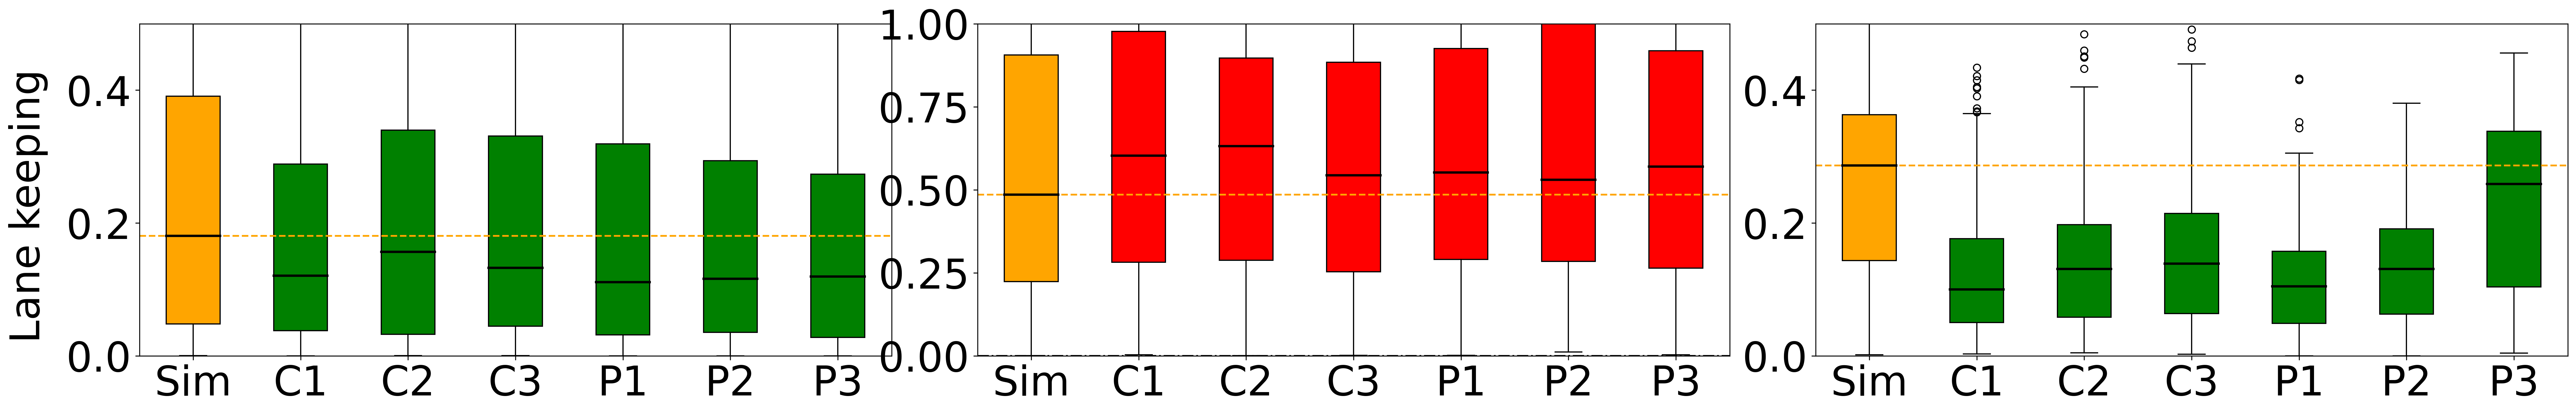

done


In [44]:
source_names_plot = ["Sim", "C1", "C2", "C3", 
                     "P1", "P2", "P3"]

fig, axes = plt.subplots(1, 3, figsize=(30, 5), dpi=300)

# PLOT 1
all_model_errors1 = []
relative_model_errors1 = []

for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            model_errors = model_loss_dict[model_type + "__" + source_name]
            all_model_errors1.append(model_errors)
            relative_loss = [abs(b_i - a_i) for a_i, b_i in zip(model_loss_dict["real__real"], model_loss_dict[model_type + "__" + source_name])]
            relative_model_errors1.append(relative_loss)
            print("model error ",model_type,source_name)
            if source_name != 'sim':
                run_wilcoxon_and_cohend(model_loss_dict["sim__sim"], model_loss_dict[model_type + "__" + source_name])

if type == "kitti":
    relative_model_errors1 = [[error / (1242) for error in errors] for errors in relative_model_errors1]
    percentile90 = np.percentile(np.hstack(relative_model_errors1), 90)
    for i, model_errors in enumerate(all_model_errors1):
        relative_model_errors1[i] = [error for error in relative_model_errors1[i] if error <= percentile90]
sim_errors1 = relative_model_errors1[source_names.index("sim")]
sim_median1 = statistics.median(sim_errors1)

boxes1 = axes[0].boxplot(relative_model_errors1, vert=True, patch_artist=True)
axes[0].axhline(sim_median1, color='orange', linestyle='--', label='Median of "Sim"')
axes[0].tick_params(axis='y', labelsize=35)

for i, box in enumerate(boxes1['boxes']):
    box_median = np.median(relative_model_errors1[i])
    if box_median < sim_median1:
        box.set_facecolor('green')
    elif box_median == sim_median1:
        box.set_facecolor('orange')
    else:
        box.set_facecolor('red')

for median in boxes1['medians']:
    median.set_color('black')
    median.set_lw(2)
print("here")
if type=='donkey':
    axes[1].set_xticklabels(source_names_plot, rotation=0, fontsize=35)

# PLOT 2
all_model_errors2 = []
relative_model_errors2 = []

for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            model_errors = model_att_dict[model_type + "__" + source_name]
            all_model_errors2.append(model_errors)
            relative_loss = [abs(a_i - b_i) for a_i, b_i in zip(model_att_dict["real__real"], model_att_dict[model_type + "__" + source_name])]
            relative_model_errors2.append(relative_loss)
            print("attention error ",model_type,source_name)
            run_wilcoxon_and_cohend(model_att_dict["real__real"], model_att_dict[model_type + "__" + source_name])

sim_errors2 = relative_model_errors2[source_names.index("sim")]
sim_median2 = statistics.median(sim_errors2)

boxes2 = axes[2].boxplot(relative_model_errors2, vert=True, patch_artist=True)
axes[2].axhline(sim_median2, color='orange', linestyle='--', label='Median of "Sim"')
axes[2].tick_params(axis='y', labelsize=35)

for i, box in enumerate(boxes2['boxes']):
    box_median = np.median(relative_model_errors2[i])
    if box_median < sim_median2:
        box.set_facecolor('green')
    elif box_median == sim_median2:
        box.set_facecolor('orange')
    else:
        box.set_facecolor('red')
print("here")
for median in boxes2['medians']:
    median.set_color('black')
    median.set_lw(2)
if type=='donkey':
    axes[2].set_xticklabels(source_names_plot, rotation=0, fontsize=35)

# PLOT 3
all_model_errors3 = []
relative_model_errors3 = []

for model_type, models in sources.items():
    for source_name in models:
        if source_name != 'real':
            model_errors = model_conf_dict[model_type + "__" + source_name]
            all_model_errors3.append(model_errors)
            if(type=='kitti'):
                relative_loss=[1-abs(abs(a_i-b_i)-a_i) if b_i>0.5 else  1-abs(abs(a_i-0.5)-a_i) for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
            else:
                relative_loss=[abs(a_i-b_i)  for a_i, b_i in zip(model_conf_dict["real__real"], model_conf_dict[model_type+"__"+source_name])]
            
            relative_model_errors3.append(relative_loss)
            print("confidence",model_type,source_name)
            run_wilcoxon_and_cohend(model_conf_dict["real__real"], model_conf_dict[model_type + "__" + source_name])

sim_errors3 = relative_model_errors3[source_names.index("sim")]
sim_median3 = statistics.median(sim_errors3)
print("here")
boxes3 = axes[1].boxplot(relative_model_errors3, vert=True, patch_artist=True)
axes[1].axhline(sim_median3, color='orange', linestyle='--', label='Median of "Sim"')
axes[1].tick_params(axis='y', labelsize=35)
axes[1].axhline(0, color='black', linestyle='dashdot', label='Median of "Sim"')
for i, box in enumerate(boxes3['boxes']):
    box_median = np.median(relative_model_errors3[i])
    if box_median > sim_median3:
        box.set_facecolor('red')
    elif box_median == sim_median3:
        box.set_facecolor('orange')
    else:
        box.set_facecolor('green')

for median in boxes3['medians']:
    median.set_color('black')
    median.set_lw(2)
print("here")
if type=='donkey':
    axes[0].set_xticklabels(source_names_plot, rotation=0, fontsize=35)

# Add a legend to the first subplot
legend_labels = ["Better than Sim", "Worse than Sim"]
legend_elements = [plt.Line2D([0], [0], color='green', lw=4, label=legend_labels[0]),
                   plt.Line2D([0], [0], color='red', lw=4, label=legend_labels[1])]

# Set titles for each subplot
if type=='kitti':
    axes[0].set_title("Relative Prediction Error", fontsize=40)
    axes[2].set_title("Relative Attention Error", fontsize=40)
    axes[1].set_title("Relative Confidence Error", fontsize=40)
# (Variance/20 predictions)
# Set a common y-axis label
if type=='donkey':
    fig.text(-0.01, 0.5, 'Lane keeping', ha='center', va='center', rotation='vertical', fontsize=35)
else:
    fig.text(-0.01, 0.5, 'Vehicle detection', ha='center', va='center', rotation='vertical', fontsize=35)
    axes[0].axes.get_xaxis().set_visible(False)
    axes[1].axes.get_xaxis().set_visible(False)
    axes[2].axes.get_xaxis().set_visible(False)
if type=='kitti':
    axes[0].set_ylim(0,15)
    axes[1].set_ylim(0,0.8)
    axes[2].set_ylim(0,15)
else:
    axes[0].set_ylim(0,0.5)
    axes[1].set_ylim(0,1)
    axes[2].set_ylim(0,0.5)

# plt.legend(handles=legend_elements, fontsize=35, loc='lower center', bbox_to_anchor=(-1, -0.7), ncol=2)
# Save the merged plot as a PNG file
plt.tight_layout()
plt.savefig('merged_plot.png', dpi=500, bbox_inches='tight')
plt.show()